In [4]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import numpy as np
import norse.torch as snn
import matplotlib.pyplot as plt
import h5py
import gc # garbage collector
from tqdm.notebook import tqdm, trange


In [5]:
INPUTS = 4
HIDDEN = 50
OUTPUTS = 3
BATCH_SIZE = 1500
T = 32
LR = 0.01
EPOCHS = 80
#file = '../data/mnist/mnist.jld2'
file = '../data/iris/iris.jld2'


In [6]:
with h5py.File(file, 'r') as f:
    train_x = torch.tensor(f['train_x'][()]).float()
    train_x = [train_x[i, :, :] for i in range(15000)]
    train_labels = f['train_labels'][()].tolist()
train_labels = [x-1 for x in train_labels]
train_data = list(zip(train_x, train_labels))
del train_x
del train_labels
gc.collect()
train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True
)
del train_data
gc.collect()


0

In [7]:
with h5py.File(file, 'r') as f:
    test_x = torch.tensor(f['test_x'][()]).float()
    test_x = [test_x[i, :, :] for i in range(15000)]
    test_labels = f['test_labels'][()].tolist()
test_labels = [x-1 for x in test_labels]
test_data = list(zip(test_x, test_labels))
del test_x
del test_labels
gc.collect()
test_loader = torch.utils.data.DataLoader(
    test_data,
    batch_size=BATCH_SIZE
)
del test_data
gc.collect()

0

In [8]:
def decode(x):
    x, _ = torch.max(x, 0)
    log_p_y = nn.functional.log_softmax(x, dim=1)
    return log_p_y


def train(model, device, train_loader, optimizer):
    model.train()
    losses = []

    for (data, target) in tqdm(train_loader, leave=False):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = nn.functional.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    mean_loss = np.mean(losses)
    return losses, mean_loss


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += nn.functional.nll_loss(
                output, target, reduction="sum"
            ).item()  # sum up batch loss
            pred = output.argmax(
                dim=1, keepdim=True
            )  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    accuracy = 100.0 * correct / len(test_loader.dataset)

    return test_loss, accuracy


class Model(nn.Module):
    def __init__(self, input_features, hidden_features, output_features):
        super(Model, self).__init__()
        self.input_features = input_features
        self.hidden_features = hidden_features
        self.output_features = output_features
        self.l1 = snn.LIFRecurrentCell(input_features, hidden_features, p=snn.LIFParameters(v_th=0.5),dt=0.001)
        self.l2 = snn.LIFRecurrentCell(hidden_features, output_features, p=snn.LIFParameters(v_th=0.5),dt=0.001)
        self.out = snn.LICell()

    def forward(self, x):
        S, T, N = x.shape
        s1 = s2 = so = None
        v = []

        for t in range(T):
            z = x[:,t,:].view(-1, self.input_features)
            z, s1 = self.l1(z, s1)
            z, s2 = self.l2(z, s2)
            z, so = self.out(z, so)
            v += [z]

        log_p_y = decode(torch.stack(v))
        return log_p_y


In [9]:
# class ConvNet(nn.Module):
#     def __init__(
#         self,  num_channels=1, feature_size=500, method="super", alpha=100
#     ):
#         super(ConvNet, self).__init__()

#         self.features = int(((feature_size - 4) / 2 - 4) / 2)

#         self.conv1 = nn.Conv2d(num_channels, 8, 5, 1)
#         self.conv2 = nn.Conv2d(8, 16, 5, 1)
#         self.fc1 = nn.Linear(self.features * self.features * 16, 500)
#         self.lif0 = snn.LIFCell(p=snn.LIFParameters(method=method, alpha=alpha))
#         self.lif1 = snn.LIFCell(p=snn.LIFParameters(method=method, alpha=alpha))
#         self.lif2 = snn.LIFCell(p=snn.LIFParameters(method=method, alpha=alpha))
#         self.out = snn.LILinearCell(500, 10)

#     def forward(self, x):
#         seq_length = x.shape[0]
#         batch_size = x.shape[1]

#         # specify the initial states
#         s0 = s1 = s2 = so = None

#         voltages = torch.zeros(
#             seq_length, batch_size, 10, device=x.device, dtype=x.dtype
#         )

#         for ts in range(seq_length):
#             z = F.max_pool2d(self.conv1(x[ts, :]), 2)
#             z, s0 = self.lif0(z, s0)
#             z = F.max_pool2d(10 * self.conv2(z), 2)
#             z, s1 = self.lif1(z, s1)
#             z = z.view(-1, self.features * self.features * 16)
#             z = self.fc1(z)
#             z, s2 = self.lif2(z, s2)
#             v, so = self.out(torch.nn.functional.relu(z), so)
#             voltages[ts, :, :] = v
#         return voltages


In [10]:
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")

print(DEVICE)

model = Model(INPUTS, HIDDEN, OUTPUTS).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)


cpu


In [11]:
# for name, param in model.named_parameters():
#     if param.requires_grad:
#         print( name, param.data)

In [12]:
training_losses = []
mean_losses = []
test_losses = []
accuracies = []

for epoch in trange(EPOCHS):
    training_loss, mean_loss = train(model, DEVICE, train_loader, optimizer)
    test_loss, accuracy = test(model, DEVICE, test_loader)
    training_losses += training_loss
    mean_losses.append(mean_loss)
    test_losses.append(test_loss)
    accuracies.append(accuracy)
    print(accuracy)


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

64.13333333333334


  0%|          | 0/10 [00:00<?, ?it/s]

64.89333333333333


  0%|          | 0/10 [00:00<?, ?it/s]

64.57333333333334


  0%|          | 0/10 [00:00<?, ?it/s]

65.68


  0%|          | 0/10 [00:00<?, ?it/s]

69.83333333333333


  0%|          | 0/10 [00:00<?, ?it/s]

72.62666666666667


  0%|          | 0/10 [00:00<?, ?it/s]

75.06666666666666


  0%|          | 0/10 [00:00<?, ?it/s]

78.18


  0%|          | 0/10 [00:00<?, ?it/s]

83.37333333333333


  0%|          | 0/10 [00:00<?, ?it/s]

84.6


  0%|          | 0/10 [00:00<?, ?it/s]

86.75333333333333


  0%|          | 0/10 [00:00<?, ?it/s]

87.33333333333333


  0%|          | 0/10 [00:00<?, ?it/s]

87.29333333333334


  0%|          | 0/10 [00:00<?, ?it/s]

87.03333333333333


  0%|          | 0/10 [00:00<?, ?it/s]

86.97333333333333


  0%|          | 0/10 [00:00<?, ?it/s]

87.3


  0%|          | 0/10 [00:00<?, ?it/s]

87.42


  0%|          | 0/10 [00:00<?, ?it/s]

87.58


  0%|          | 0/10 [00:00<?, ?it/s]

86.86666666666666


  0%|          | 0/10 [00:00<?, ?it/s]

87.19333333333333


  0%|          | 0/10 [00:00<?, ?it/s]

85.31333333333333


  0%|          | 0/10 [00:00<?, ?it/s]

87.65333333333334


  0%|          | 0/10 [00:00<?, ?it/s]

85.0


  0%|          | 0/10 [00:00<?, ?it/s]

86.54666666666667


  0%|          | 0/10 [00:00<?, ?it/s]

87.60666666666667


  0%|          | 0/10 [00:00<?, ?it/s]

86.94666666666667


  0%|          | 0/10 [00:00<?, ?it/s]

87.20666666666666


  0%|          | 0/10 [00:00<?, ?it/s]

87.46666666666667


  0%|          | 0/10 [00:00<?, ?it/s]

87.78666666666666


  0%|          | 0/10 [00:00<?, ?it/s]

86.86666666666666


  0%|          | 0/10 [00:00<?, ?it/s]

87.86


  0%|          | 0/10 [00:00<?, ?it/s]

86.88666666666667


  0%|          | 0/10 [00:00<?, ?it/s]

87.63333333333334


  0%|          | 0/10 [00:00<?, ?it/s]

86.0


  0%|          | 0/10 [00:00<?, ?it/s]

86.98666666666666


  0%|          | 0/10 [00:00<?, ?it/s]

87.94


  0%|          | 0/10 [00:00<?, ?it/s]

86.83333333333333


  0%|          | 0/10 [00:00<?, ?it/s]

87.83333333333333


  0%|          | 0/10 [00:00<?, ?it/s]

87.4


  0%|          | 0/10 [00:00<?, ?it/s]

88.28


  0%|          | 0/10 [00:00<?, ?it/s]

88.27333333333333


  0%|          | 0/10 [00:00<?, ?it/s]

87.78666666666666


  0%|          | 0/10 [00:00<?, ?it/s]

87.36


  0%|          | 0/10 [00:00<?, ?it/s]

84.96666666666667


  0%|          | 0/10 [00:00<?, ?it/s]

88.22666666666667


  0%|          | 0/10 [00:00<?, ?it/s]

86.76666666666667


  0%|          | 0/10 [00:00<?, ?it/s]

87.51333333333334


  0%|          | 0/10 [00:00<?, ?it/s]

88.44666666666667


  0%|          | 0/10 [00:00<?, ?it/s]

88.05333333333333


  0%|          | 0/10 [00:00<?, ?it/s]

88.18666666666667


  0%|          | 0/10 [00:00<?, ?it/s]

86.30666666666667


  0%|          | 0/10 [00:00<?, ?it/s]

88.15333333333334


  0%|          | 0/10 [00:00<?, ?it/s]

88.2


  0%|          | 0/10 [00:00<?, ?it/s]

88.39333333333333


  0%|          | 0/10 [00:00<?, ?it/s]

88.56


  0%|          | 0/10 [00:00<?, ?it/s]

87.87333333333333


  0%|          | 0/10 [00:00<?, ?it/s]

88.43333333333334


  0%|          | 0/10 [00:00<?, ?it/s]

88.42


  0%|          | 0/10 [00:00<?, ?it/s]

88.38666666666667


  0%|          | 0/10 [00:00<?, ?it/s]

88.71333333333334


  0%|          | 0/10 [00:00<?, ?it/s]

89.03333333333333


  0%|          | 0/10 [00:00<?, ?it/s]

88.48666666666666


  0%|          | 0/10 [00:00<?, ?it/s]

88.51333333333334


  0%|          | 0/10 [00:00<?, ?it/s]

88.64


  0%|          | 0/10 [00:00<?, ?it/s]

88.12


  0%|          | 0/10 [00:00<?, ?it/s]

88.68666666666667


  0%|          | 0/10 [00:00<?, ?it/s]

88.28666666666666


  0%|          | 0/10 [00:00<?, ?it/s]

88.41333333333333


  0%|          | 0/10 [00:00<?, ?it/s]

87.58


  0%|          | 0/10 [00:00<?, ?it/s]

88.08666666666667


  0%|          | 0/10 [00:00<?, ?it/s]

88.55333333333333


  0%|          | 0/10 [00:00<?, ?it/s]

88.30666666666667


  0%|          | 0/10 [00:00<?, ?it/s]

88.54666666666667


  0%|          | 0/10 [00:00<?, ?it/s]

88.63333333333334


  0%|          | 0/10 [00:00<?, ?it/s]

88.82


  0%|          | 0/10 [00:00<?, ?it/s]

88.53333333333333


  0%|          | 0/10 [00:00<?, ?it/s]

88.80666666666667


  0%|          | 0/10 [00:00<?, ?it/s]

88.56


  0%|          | 0/10 [00:00<?, ?it/s]

88.8


  0%|          | 0/10 [00:00<?, ?it/s]

89.12


In [13]:
# for name, param in model.named_parameters():
#     if param.requires_grad:
#         print( name, param.data)

88.61777777777777
0.5133333333333212


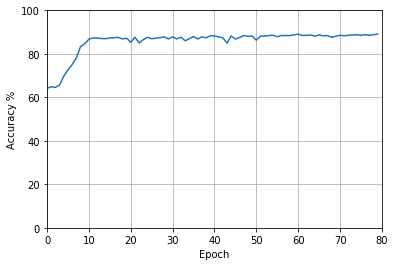

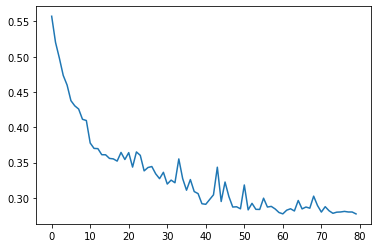

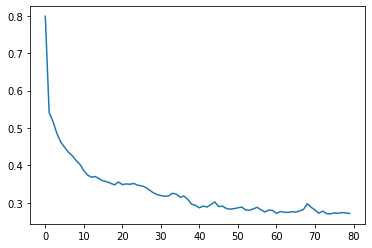

In [14]:
from statistics import mean


plt.figure(0)
plt.plot(accuracies)
plt.ylim(0,100)
plt.ylabel("Accuracy %")
plt.xlabel("Epoch")
plt.xlim(0,80)
plt.grid(True)
plt.figure(1)
plt.plot(test_losses)
plt.figure(2)
plt.plot(mean_losses)

print(mean(accuracies[-10:-1]))
print(max(accuracies[-10:-1])-min(accuracies[-10:-1]))
